In [1]:
# Import
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as inter 
import scipy.integrate as integrate
from scipy.integrate import quad
from scipy.special import ellipe
from scipy.special import ellipk
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Parameters for Galaxy NGC 5533
G = 4.300e-6                                                #gravitational constant (kpc/solar mass*(km/s)^2)
h = 8.9                                                     #radial scale-length (kpc)
rho00 = 0.31e9                                              #central 3D density (solar mass/kpc^2) 
epsdisk = 5.0                                               #mass-to-light ratio disk
absmag = -22.02                                             #absolute magnitude 
magsun = 4.42                                               #absolute magnitude of the sun

z0 = lambda h: 0.2*h                                        #half-thickness (kpc)
R = lambda h: 4*h                                           #cut-off radius (kpc)
d = lambda h: 0.2*h                                         #cut-off length upper limits (kpc)

rd = np.linspace(0.1, 150, num=500)

[1.64006981e-02 3.88501738e+00 7.87588903e+00 1.17575631e+01
 1.57546738e+01 1.96291348e+01 2.37401817e+01 2.75064980e+01
 3.13903044e+01 3.56194206e+01 3.93728638e+01 4.35945825e+01
 4.73517376e+01 5.12228289e+01 5.52093832e+01 5.94341030e+01
 6.33070897e+01 6.70612174e+01 7.11660515e+01 7.50371691e+01
 7.91434774e+01 8.31321114e+01 8.70029394e+01 9.09909416e+01]


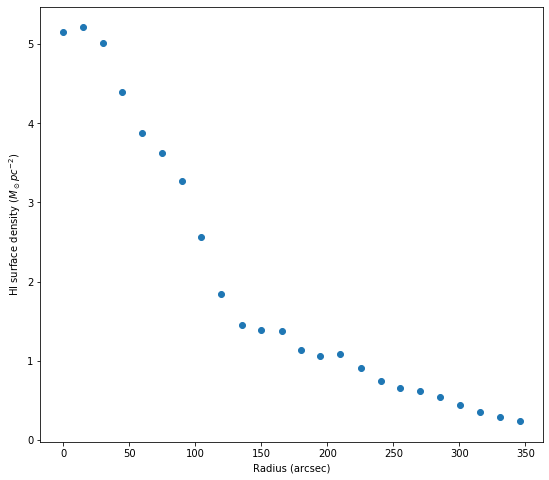

In [3]:
# H1 surface mass density data from https://www.aanda.org/articles/aa/full/2005/40/aa3172-05/aa3172-05_online.html
# Used DataThief to get data from image
h1data = np.loadtxt("../data/h1data.txt")
rarcsec, h1smd = h1data.T

# Converting arcseconds to kpc for radius measurements
D = 54.3         # in Mpc
rkpc = rarcsec*D*1000/206265                # calculated using http://astro.physics.uiowa.edu/ITU/glossary/small-angle-formula/
print(rkpc)

# Plot HI surface density
plt.figure(figsize=(9,8))
plt.scatter(rarcsec,h1smd)
plt.xlabel("Radius (arcsec)")
plt.ylabel("HI surface density ($M_\odot pc^{-2}$)")
plt.show()

# Does this measured H1 data equal rho00?
rho00data = inter.UnivariateSpline(rkpc, h1smd, k=3)

In [4]:
# Definitions
def x(r,u,xi):
    return ((r**2)+(u**2)+(xi**2))/(2*r*u)

def px(r,u,xi):
    return x(r,u,xi)-(np.sqrt((x(r,u,xi)**2)-1))

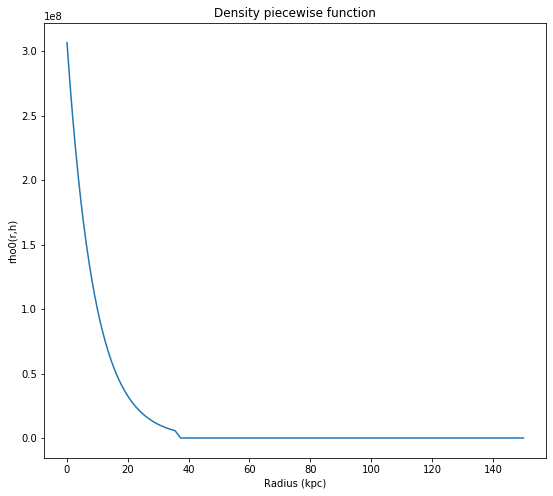

In [5]:
# Density piecewise function
def rho0(r,h):
    condlist = [r <= R(h), (r > R(h)) & (r <= (R(h)+d(h))), r > (R(h)+d(h))]
    funclist = [lambda r: rho00*np.exp(-r/h), lambda r: rho00*np.exp(-R(h)/h)*(1-(r-R(h))/d(h)), lambda r: 0]
    return np.piecewise(r, condlist, funclist)

# Plot 
plt.figure(figsize=(9,8))
plt.plot(rd,rho0(rd,h))
plt.title("Density piecewise function")
plt.xlabel("Radius (kpc)")
plt.ylabel("rho0(r,h)")
plt.show()

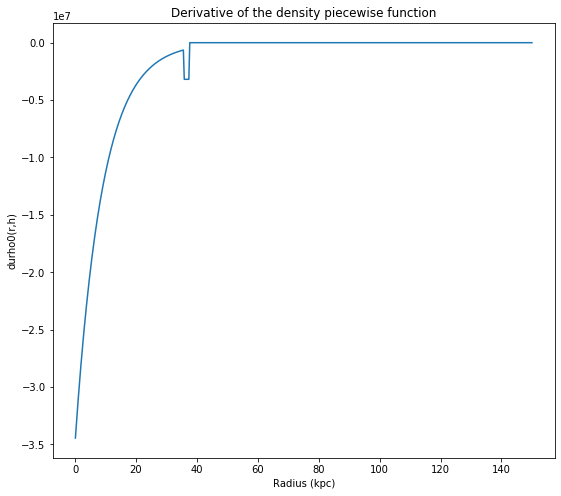

In [6]:
# Partial derivative of rho0
def durho0(r,h):
    condlist = [r <= R(h), (r > R(h)) & (r <= (R(h)+d(h))), r > (R(h)+d(h))]
    funclist = [lambda r: -(1/h)*rho00*np.exp(-r/h), lambda r: -(1/d(h))*rho00*np.exp(-R(h)/h), lambda r: 0]
    return np.piecewise(r, condlist, funclist)

# Plot 
plt.figure(figsize=(9,8))
plt.plot(rd,durho0(rd,h))
plt.title("Derivative of the density piecewise function")
plt.xlabel("Radius (kpc)")
plt.ylabel("durho0(r,h)")
plt.show()

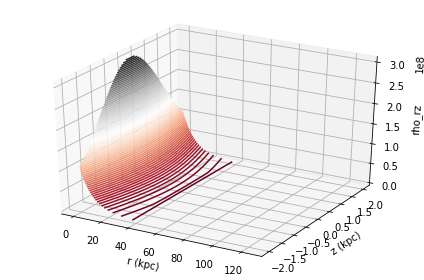

In [7]:
# Disk density distribution
def rho_rz(r,z,h):
    rho_rz = rho0(r,h)*(np.power(np.cosh(z/z0(h)), (-2)))
    return rho_rz

# Plot
za = np.linspace(-2, 2, 500)
ra = np.linspace(0.1, 125, 500)

RA, ZA = np.meshgrid(ra, za)
RZ = rho_rz(RA, ZA, h)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(RA, ZA, RZ, 100, cmap='RdGy')

plt.tight_layout()
ax.set_xlabel('r (kpc)')
ax.set_ylabel('z (kpc)')
ax.set_zlabel('rho_rz');

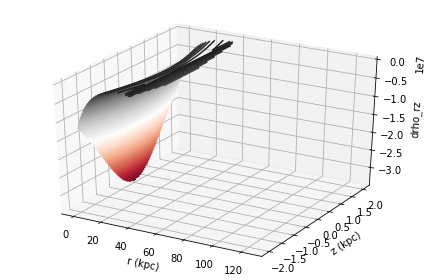

In [8]:
# Derivative of the disk density distribution
def drho_rz(r,z,h):
    drho_rz = durho0(r,h)*(np.power(np.cosh(z/z0(h)), (-2)))
    return drho_rz

# Plot
DRA, DZA = np.meshgrid(ra, za)
DRZ = drho_rz(DRA, DZA, h)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(DRA, DZA, DRZ, 100, cmap='RdGy')

plt.tight_layout()
ax.set_xlabel('r (kpc)')
ax.set_ylabel('z (kpc)')
ax.set_zlabel('drho_rz');

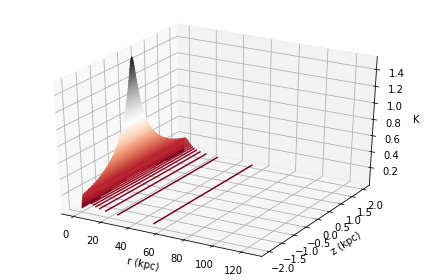

In [9]:
# Complete elliptic integral
def K(r,u,z):
    K = ellipk(px(r,u,z)) - ellipe(px(r,u,z))
    return K

# Plot
KRA, KZA = np.meshgrid(ra, za)
KRZ = K(KRA,1,KZA)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(KRA, KZA, KRZ, 100, cmap='RdGy')

plt.tight_layout()
ax.set_xlabel('r (kpc)')
ax.set_ylabel('z (kpc)')
ax.set_zlabel('K');

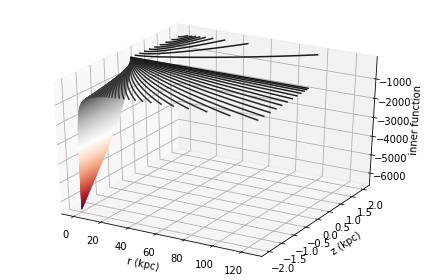

In [10]:
# Inner function
def innerf(r,u,z,h): 
    innerf = u*drho_rz(u,z,h)*2*K(r,u,z)/(np.pi*np.sqrt(r*u*px(r,u,z)))
    return innerf

# Plot
INNERFRA, INNERFZA = np.meshgrid(ra, za)
INNERFRZ = innerf(INNERFRA,INNERFZA,10,h)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(INNERFRA, INNERFZA, INNERFRZ, 500, cmap='RdGy')

plt.tight_layout()
ax.set_xlabel('r (kpc)')
ax.set_ylabel('u (kpc)')
ax.set_zlabel('inner function');

In [13]:
# Integrate function
innerf2 = lambda z,r,u,h: innerf(r,u,z,h)

def intinnerf(r,u,h): 
    intin = quad(innerf2, 0.1, R(h)+d(h), args=(r,u,h))[0]
    return intin

# Plot
INTINRA, INTINZA = np.meshgrid(ra, za)
INTINRZ = intinnerf(INTINRA,INTINZA,h)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(INTINRA, INTINZA, INTINRZ, 100, cmap='RdGy')

plt.tight_layout()
ax.set_xlabel('r (kpc)')
ax.set_ylabel('u (kpc)')
ax.set_zlabel('Inner integral');

TypeError: only size-1 arrays can be converted to Python scalars

In [ ]:
# Integrate outer function
def intinnerf2(u,r,h): 
    intinnerf2 = intinnerf(r,u,h)
    return intinnerf2

intouterf = lambda r,h: quad(intinnerf2, 0.1, R(h)+d(h), args=(r,h,))[0]

# Plot 
plt.figure(figsize=(9,8))
plt.plot(rd,intouterf(rd,h))
plt.title("Outer integral")
plt.xlabel("Radius (kpc)")
plt.ylabel("intouter(r,h)")
plt.show()

In [ ]:
# Radial force
F = lambda r,h: 4*np.pi*G*intouterf(r,h)

# Plot 
plt.figure(figsize=(9,8))
plt.plot(rd,F(rd,h))
plt.title("Radial Force")
plt.xlabel("Radius (kpc)")
plt.ylabel("F(r,h)")
plt.show()

In [ ]:
#disk velocity
Fv = np.vectorize(F)
v = np.sqrt(-rd*Fv(rd))

In [ ]:
#plot disk velocity
fig = plt.figure(figsize=(9.0,8.0))                #size of the plot
ax = plt.axes()
ax.grid(True)
ax.yaxis.grid(True,which='minor',linestyle='--')

plt.plot(rd, v, linestyle='solid', label='Disk Velocity')

plt.axis('tight');

fig.suptitle('Disk Velocity', fontsize=18)
ax.set(title='NGC 5533')              #labeling axes
ax.set_xlim(0,100)
ax.set_xlabel('r (kpc)', fontsize=14)
ax.set_ylabel('v (km/s)', fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14);

plt.legend(fontsize=16);                                   #adding legend
#plt.savefig('DiskVelocity100pts.png')
plt.show()